In [37]:
import numpy as np
from sklearn.utils import shuffle
from pickle import dump
import os
from tqdm import tqdm
import string
from keras.preprocessing import sequence
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from datetime import datetime as dt
import numpy as np
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tqdm import tqdm
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, concatenate, RepeatVector, TimeDistributed, Bidirectional, Flatten
from nltk.translate.bleu_score import corpus_bleu
from keras.applications.xception import Xception
import numpy as np
import random
from keras.preprocessing.sequence import pad_sequences
from pickle import load, dump
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow import keras
from pickle import load
import matplotlib.pyplot as plt
import argparse
from keras.models import load_model
from PIL import Image
from keras.layers.merge import add
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from keras.utils import plot_model

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def cnn(model_selection):
  if model_selection == 'inceptionv3':
      model = InceptionV3()
  if model_selection == 'vgg16':
      model = VGG16()
  elif model_selection == 'Xception':
      model = Xception()
  new_model = Model(model.input, model.layers[-2].output)
  return new_model

Extracing feature vector from inceptionv3, vgg16 and exception model

In [4]:
def features_extraction(path, model_selection):
    if model_selection == 'inceptionv3':
        from keras.applications.inception_v3 import preprocess_input
        size = (299, 299)
    elif model_selection == 'vgg16':
        from keras.applications.vgg16 import preprocess_input
        size = (224, 224)
    elif model_selection == 'Xception':
        from keras.applications.xception import preprocess_input
        size = (299,299)
    model = cnn(model_selection)
    features = dict()
    for name in tqdm(os.listdir(path)):
        filename = path + name
        img = load_img(filename, target_size=size)
        img = image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        img_id = name.split('.')[0]
        feature = np.reshape(feature,feature.shape[1])
        features[img_id] = feature
    return features

RNN model with LSTM

In [5]:
def rnn(vocab_size, max_len, model_config, model_selection):
    embedding_size = model_config['embeddingsize']
    if model_selection == 'inceptionv3':
        input_image = Input(shape=(2048,))
    elif model_selection == 'Xception':
        input_image = Input(shape=(2048,))
    im = Dropout(model_config['dropout'])(input_image)
    image = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(im)

    input_caption = Input(shape=(max_len,))
    cm1 = Embedding(vocab_size, embedding_size, mask_zero=True)(input_caption)
    cm2 = Dropout(model_config['dropout'])(cm1)
    caption = LSTM(model_config['lstm'])(cm2)

    decoder1 = concatenate([image, caption])
    decoder2 = Dense(model_config['dense'], activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder1)
    output_model = Dense(vocab_size, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder2)

    model = Model(inputs=[input_image, input_caption], outputs=output_model)
    return model


RNN model with Bi-LSTM

In [6]:
def bidirectional_model(vocab_size, max_len, model_config, model_selection):
    embedding_size = model_config['embeddingsize']
    if model_selection == 'inceptionv3':
        input_image = Input(shape=(2048,))
    elif model_selection == 'Xception':
        input_image = Input(shape=(2048,))
    im = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(input_image)
    image = RepeatVector(max_len)(im)

    input_caption = Input(shape=(max_len,))
    cm1 = Embedding(vocab_size, embedding_size, mask_zero=True)(input_caption)
    cm2 = LSTM(model_config['lstm'], return_sequences=True)(cm1)
    caption = TimeDistributed(Dense(embedding_size))(cm2)

    decoder1 = concatenate([image, caption])
    decoder2 = Bidirectional(LSTM(model_config['lstm'], return_sequences=False))(decoder1)
    decoder3 = Dense(embedding_size, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder2)
    decoder4 = Dropout(model_config['dropout'])(decoder3)
    output_model = Dense(vocab_size, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.01))(decoder4)
  
    model = Model(inputs=[input_image, input_caption], outputs=output_model)
    return model

Generating description from trained model using greedy search and beam search

In [7]:
def generate_word_from_int(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_description(model, tokenizer, image, max_len):
    desp = 'startseq'
    for i in range(max_len):
        seq = tokenizer.texts_to_sequences([desp])[0]
        seq = pad_sequences([seq], maxlen=max_len)
        pred = model.predict([image,seq], verbose=0)
        pred = np.argmax(pred)
        word = generate_word_from_int(pred, tokenizer)
        if word is None:
            break
        desp += ' ' + word
        if word == 'endseq':
            break
    return desp


def model_evaluation(model, tokenizer, images, captions, max_len, beam_index):
    actual, prediction = list(), list()
    for img_id, cap_list in tqdm(captions.items()):
        images[img_id] = images[img_id].reshape((1,2048))
        pred = generate_caption_beam_search(model, tokenizer, images[img_id], max_len, beam_index = 3)
        truth = [caption.split() for caption in cap_list]
        actual.append(truth)
        prediction.append(pred.split())
    print('BLEU Scores :')
    print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
    print('BLEU-1: %f' % corpus_bleu(actual, prediction, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, prediction, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, prediction, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, prediction, weights=(0.25, 0.25, 0.25, 0.25)))

def model_evaluation_greedy_search(model, tokenizer, images, captions, max_len):
    actual, prediction = list(), list()
    for img_id, cap_list in tqdm(captions.items()):
        images[img_id] = images[img_id].reshape((1,2048))
        pred = generate_description(model, tokenizer, images[img_id], max_len)
        truth = [caption.split() for caption in cap_list]
        actual.append(truth)
        prediction.append(pred.split())
    print('BLEU Scores :')
    print('A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.')
    print('BLEU-1: %f' % corpus_bleu(actual, prediction, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, prediction, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, prediction, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, prediction, weights=(0.25, 0.25, 0.25, 0.25)))

Extracting image id and captions from flickr8k dataset and storing it as a dictionary.

In [8]:
def loading_captions(filename):
    file = open(filename, 'r')
    doc = file.read()
    file.close()

    caps = dict()
    for line in doc.split('\n'):
        tokens = line.split()
        if len(line) < 2:
            continue
        img_id, img_cap = tokens[0], tokens[1:]
        img_id = img_id.split('.')[0]
        img_cap = ' '.join(img_cap)
        if img_id not in caps:
            caps[img_id] = list()
        caps[img_id].append(img_cap)
    return caps

def text_cleaning(caps):
    table = str.maketrans('', '', string.punctuation)
    for key, cap_list in caps.items():
        for i in range(len(cap_list)):
            caption = cap_list[i]
            caption = caption.split()
            caption = [word.lower() for word in caption]
            caption = [w.translate(table) for w in caption]
            caption = [word for word in caption if len(word)>1]
            caption = [word for word in caption if word.isalpha()]
            cap_list[i] =  ' '.join(caption)
        caps[key]=cap_list
    return caps


def save_cleaned_texts(caps, filename):
    lines = list()
    for key, cap_list in caps.items():
        for caption in cap_list:
            lines.append(key + ' ' + caption)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [9]:
def Data_preprocessing(path1,path2,cap_path,model_selection):
    if os.path.exists(path1+'features_'+model_selection+'.pkl'):
        print('Features for images are already generated at the location {}'.format(path1+'features_'+model_selection+'.pkl'))
    else:
        print('Generating the image features')
        features = features_extraction(path2, model_selection)
        dump(features, open(path1+'features_'+model_selection+'.pkl', 'wb'))
        print('Features are saved')
    if os.path.exists(path1+'captions.txt'):
        print('Captions for the images are already generated at the location {}'.format(path1+'captions.txt'))
    else:
        descriptions = loading_captions(cap_path)
        print(type(descriptions))
        print(descriptions)
        descriptions=text_cleaning(descriptions)
        print(type(descriptions))
        print(descriptions)
        save_cleaned_texts(descriptions, path1+'captions.txt')
        print('Captions are successfully generated')

In [10]:
captions_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr8k.token.txt"
descriptions = loading_captions(captions_path)
print(type(descriptions))
#print(descriptions)
descriptions=text_cleaning(descriptions)
#print(descriptions)
unique_vocab = set()
for key in descriptions.keys():
  [unique_vocab.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(unique_vocab))

<class 'dict'>
Original Vocabulary Size: 8763


In [11]:
path_for_extracted_features_captions = "/content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/"
model_types=['inceptionv3','vgg16','Xception']
image_dataset_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flicker8k_Dataset/"
captions_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr8k.token.txt"

for i in range(len(model_types)):
    Data_preprocessing(path_for_extracted_features_captions,image_dataset_path,captions_path,model_types[i])

Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_inceptionv3.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt
Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_vgg16.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt
Features for images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/features_Xception.pkl
Captions for the images are already generated at the location /content/gdrive/MyDrive/DEEP LEARNING/final/features_and_captions/captions.txt


In [12]:
def extract_img_ids(filename):
    f = open(filename, 'r')
    r = f.read()
    f.close()
    ids = list()
    for i in r.split('\n'):
        if len(i) < 1:
            continue
        img_id = i.split('.')[0]
        ids.append(img_id)
    return set(ids)

In [13]:
def load_cleaned_descriptions(filename, ids):
    f = open(filename, 'r')
    doc = f.read()
    f.close()
    image_captions = dict()
    for line in doc.split('\n'):
        img_id_desp = line.split()
        img_id, img_cap = img_id_desp[0], img_id_desp[1:]
        if img_id in ids:
            if img_id not in image_captions:
                image_captions[img_id] = list()
            desp = 'startseq ' + ' '.join(img_cap) + ' endseq'
            image_captions[img_id].append(desp)
    return image_captions

In [14]:
def load_features(filename, ids):
    img_features = load(open(filename, 'rb'))
    features = {i: img_features[i] for i in ids}
    return features

In [15]:
def convert_to_list(desp):
    img_desp = list()
    for img_id in desp.keys():
        [img_desp.append(cap) for cap in desp[img_id]]
    return img_desp

In [16]:
def tokenizing(desp):
    desp_list = convert_to_list(desp)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desp_list)
    return tokenizer

In [17]:
def maximum_length(desp):
    desp_list = convert_to_list(desp)
    return max(len(i.split()) for i in desp_list)

Generating sequence from the captions list to feed it into the model. The captions will be sequenced with a startseq appened to the captions at the front end and endseq been appended to the captions end to make the model identify the start and the end of the captions.

---
The generator will send the data batch wise to restrict more data being added on to the memory.


In [18]:
def generate_seq_update(image_features, description, max_len, batch_size, vocab_size, tokenizer):
  X1, X2, y = list(), list(), list()
  count = 0
  while 1:
    for key, desp_list in description.items():
      count = count+1
      img_feature = image_features[key]
      for desp in desp_list:
        seq = tokenizer.texts_to_sequences([desp])[0]
        for i in range(1, len(seq)):
            input_seq, output_seq = seq[:i], seq[i]
            input_seq = pad_sequences([input_seq], maxlen=max_len)[0]
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            X1.append(img_feature)
            X2.append(input_seq)
            y.append(output_seq)
      if count == batch_size:
        X_train=[np.array(X1),np.array(X2)]
        Y_train=np.array(y)
        yield (X_train,Y_train)
        X1, X2, y = list(), list(), list()
        count=0

Getting training data

In [19]:
def get_train_data(train_dataset_path,path1,model_selection):
    img_ids_train = extract_img_ids(train_dataset_path)
    desp_train = load_cleaned_descriptions(path1+'captions.txt', img_ids_train)
    #print(desp_train)
    img_features_train = load_features(path1+'features_'+model_selection+'.pkl', img_ids_train)
    if not os.path.exists(path1+'tokenizer.pkl'):
        tokenizer = tokenizing(desp_train)
        dump(tokenizer, open(path1+'tokenizer.pkl', 'wb'))
    max_len = maximum_length(desp_train)
    return img_features_train, desp_train, max_len

Getting validation data

In [20]:
def get_val_data(val_dataset_path,path1,model_selection):
    img_ids_val = extract_img_ids(val_dataset_path)
    desp_val = load_cleaned_descriptions(path1+'captions.txt', img_ids_val)
    img_features_val = load_features(path1+'features_'+model_selection+'.pkl', img_ids_val)
    return img_features_val, desp_val

Using pretrained word embeddings of glove model

In [21]:
embeddings_index = {} 
f = open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/glove.6B.200d.txt", encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

Creating a matrix out of the embedding vectors and tokenized words

In [22]:
tokenizer = load(open(path_for_extracted_features_captions+'tokenizer.pkl', 'rb'))
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
print(embedding_matrix.shape)

(7579, 200)


The model selection like xception or inceptionv3 or vgg16 is made here

In [23]:
train_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.trainImages.txt"
val_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.devImages.txt"
model_selection = "Xception"
train_features, train_captions, max_len = get_train_data(train_dataset,path_for_extracted_features_captions,model_selection)
val_features,val_captions = get_val_data(val_dataset,path_for_extracted_features_captions,model_selection)
print(train_features['10815824_2997e03d76'])

[0.02142421 0.1410758  0.09508835 ... 0.07635967 0.17963612 0.01355512]


In [24]:
print(len(train_features),type(train_features))
print(len(val_features),type(val_features))
print(max_len)
print(train_captions['2513260012_03d33305cf'])

6000 <class 'dict'>
1000 <class 'dict'>
34
['startseq black dog is running after white dog in the snow endseq', 'startseq black dog chasing brown dog through snow endseq', 'startseq two dogs chase each other across the snowy ground endseq', 'startseq two dogs play together in the snow endseq', 'startseq two dogs running through low lying body of water endseq']


In [25]:
model_config={'dropout':0.3, 'dense':256, 'lstm':256, 'embeddingsize':200}

In [26]:
model = bidirectional_model(vocab_size, max_len, model_config, model_selection)

The weights of glove are already trained, so setting the embedding layer of the model to false, because we dont have to train it again.

In [27]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

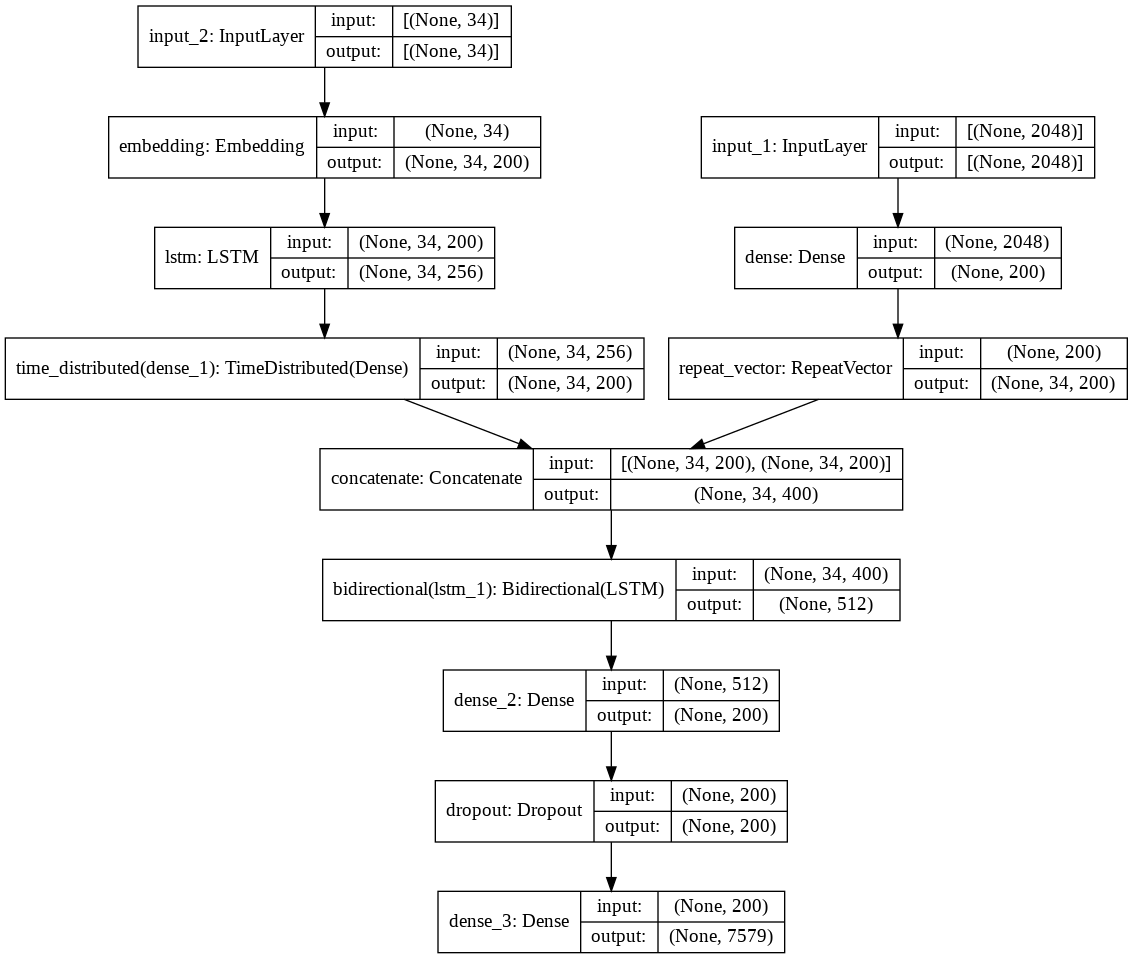

In [28]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

In [29]:
[a,b],c = next(generate_seq_update(train_features, train_captions, max_len, 1, vocab_size, tokenizer))
print(a.shape, b.shape, c.shape)
print(c)

(47, 2048) (47, 34) (47, 7579)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [30]:
print(model.summary())
print(len(train_features))
print(len(train_captions))
print(vocab_size)
print(max_len)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 200)      1515800     input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 200)          409800      input_1[0][0]                    
______________________________________________________________________________________________

I carried out different experiments using different batch sizes and different number of epochs to see the model performance and to avoid overfitting for every epoch validation loss is also monitored

---
I have used different number of epochs and batch sizes by overwriting the same cell down below. So I can't able to show all the combinations that I have tried out.


In [31]:
batch_size = 16
train_steps = np.ceil(len(train_captions)/batch_size)
val_steps  = np.ceil(len(val_captions)/batch_size)
epochs=15
print(train_steps,val_steps)
model_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+'bidirectional_LSTM_model_glove.hdf5'
#checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpointer = [checkpoint]
history_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+"bidirectional_LSTM_model_glove"

375.0 63.0


Experiment using Inceptionv3/LSTM and Inceptionv3/Bi-LSMT
Xception/LSTM and Xception/Bi-LSMT are carried out.

In [32]:
train_data_generator = generate_seq_update(train_features, train_captions, max_len, batch_size, vocab_size, tokenizer)
val_data_generator = generate_seq_update(val_features, val_captions, max_len, batch_size, vocab_size, tokenizer)
history = model.fit(train_data_generator, epochs=epochs, steps_per_epoch = train_steps, validation_data=val_data_generator, validation_steps= val_steps, verbose=1)
model.save(model_save_path)
with open(history_save_path, 'wb') as file_pi:
  dump(history.history, file_pi)
print("Done with epoch ")
print('\n\n\n\n')

Epoch 1/15
375/375 [==============================] - 100s 237ms/step - loss: 8.1124 - accuracy: 0.1028 - val_loss: 5.4646 - val_accuracy: 0.1753
Epoch 2/15
375/375 [==============================] - 85s 228ms/step - loss: 5.4153 - accuracy: 0.1766 - val_loss: 5.2515 - val_accuracy: 0.1904
Epoch 3/15
375/375 [==============================] - 86s 228ms/step - loss: 5.2286 - accuracy: 0.1916 - val_loss: 5.1092 - val_accuracy: 0.2085
Epoch 4/15
375/375 [==============================] - 86s 230ms/step - loss: 5.1043 - accuracy: 0.2105 - val_loss: 5.0136 - val_accuracy: 0.2260
Epoch 5/15
375/375 [==============================] - 86s 229ms/step - loss: 5.0079 - accuracy: 0.2275 - val_loss: 4.9533 - val_accuracy: 0.2313
Epoch 6/15
375/375 [==============================] - 86s 229ms/step - loss: 4.9405 - accuracy: 0.2353 - val_loss: 4.9076 - val_accuracy: 0.2362
Epoch 7/15
375/375 [==============================] - 86s 228ms/step - loss: 4.8849 - accuracy: 0.2450 - val_loss: 4.8654 - val_a

In [33]:
'''used for extracting test features'''

def test_feature_extraction(path, model_selection):
    if model_selection == 'inceptionv3':
        from keras.applications.inception_v3 import preprocess_input
        size = (299, 299)
    elif model_selection == 'vgg16':
        from keras.applications.vgg16 import preprocess_input
        size = (224, 224)
    elif model_selection == 'Xception':
        from keras.applications.xception import preprocess_input
        size = (299,299)
    model = cnn(model_selection)
    features = dict()
    for name in tqdm(os.listdir(path)):
        filename = path + name
        img = load_img(filename, target_size=size)
        img = image.img_to_array(img)
        img = np.expand_dims(img,axis=0)
        img = preprocess_input(img)
        feature = model.predict(img)
        img_id = name.split('.')[0]
        feature = np.reshape(feature,feature.shape[1])
    return feature

In [34]:
def generate_caption_beam_search(model, tokenizer, image, max_length, beam_index=3):
	in_text = [[tokenizer.texts_to_sequences(['startseq'])[0], 0.0]]
	while len(in_text[0][0]) < max_length:
		tempList = []
		for seq in in_text:
			padded_seq = pad_sequences([seq[0]], maxlen=max_length)
			preds = model.predict([image,padded_seq], verbose=0)
			top_preds = np.argsort(preds[0])[-beam_index:]
			for word in top_preds:
				next_seq, prob = seq[0][:], seq[1]
				next_seq.append(word)
				prob += preds[0][word]
				tempList.append([next_seq, prob])
		in_text = tempList
		in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
		in_text = in_text[-beam_index:]
	in_text = in_text[-1][0]
	final_caption_raw = [generate_word_from_int(i,tokenizer) for i in in_text]
	final_caption = []
	for word in final_caption_raw:
		if word=='endseq':
			break
		else:
			final_caption.append(word)
	final_caption.append('endseq')
	return ' '.join(final_caption)

In [35]:
test_data_path = "/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/"

100%|██████████| 1000/1000 [1:29:55<00:00,  5.40s/it]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.529573
BLEU-2: 0.278877
BLEU-3: 0.171047


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-4: 0.071199


100%|██████████| 1000/1000 [08:39<00:00,  1.92it/s]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.518783
BLEU-2: 0.267699
BLEU-3: 0.166667
BLEU-4: 0.066599
startseq man in red shirt is standing in the water endseq
beam startseq man in red shirt is standing in the water endseq


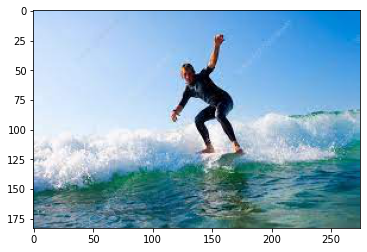

In [38]:
max_len = 34

feature = test_feature_extraction(test_data_path, "Xception")
feature = feature.reshape((1,2048))
img = Image.open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/test1.jpg")


plt.imshow(img)
model_evaluation(model, tokenizer, val_features, val_captions, max_len, 3)
model_evaluation_greedy_search(model, tokenizer, val_features, val_captions, max_len)
description = generate_description(model, tokenizer, feature, max_len)
beam_descrption = generate_caption_beam_search(model, tokenizer, feature, max_len, 3)
print(description)
print("beam", beam_descrption) 

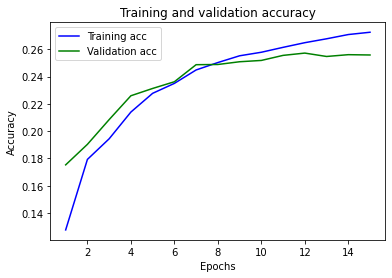

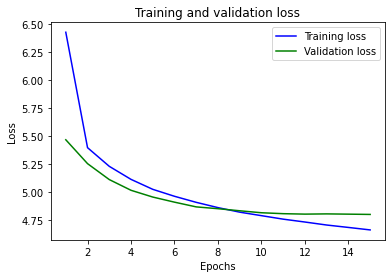

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [40]:
train_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.trainImages.txt"
val_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.devImages.txt"
model_selection = "inceptionv3"
train_features, train_captions, max_len = get_train_data(train_dataset,path_for_extracted_features_captions,model_selection)
val_features,val_captions = get_val_data(val_dataset,path_for_extracted_features_captions,model_selection)
print(train_features['10815824_2997e03d76'])

[0.34266418 0.16739696 0.09924389 ... 0.21216701 0.46709603 0.25276417]


In [41]:
model2 = bidirectional_model(vocab_size, max_len, model_config, model_selection)
model2.layers[2].set_weights([embedding_matrix])
model2.layers[2].trainable = False
opt = keras.optimizers.Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [42]:
batch_size = 16
train_steps = np.ceil(len(train_captions)/batch_size)
val_steps  = np.ceil(len(val_captions)/batch_size)
epochs=15
print(train_steps,val_steps)
model_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/inception/model_"+model_selection+'bidirectional_LSTM_model_glove.hdf5'
#checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpointer = [checkpoint]
history_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/inception/model_"+model_selection+"bidirectional_LSTM_model_glove"

375.0 63.0


In [43]:
train_data_generator = generate_seq_update(train_features, train_captions, max_len, batch_size, vocab_size, tokenizer)
val_data_generator = generate_seq_update(val_features, val_captions, max_len, batch_size, vocab_size, tokenizer)
history2 = model2.fit(train_data_generator, epochs=epochs, steps_per_epoch = train_steps, validation_data=val_data_generator, validation_steps= val_steps, verbose=1)
model2.save(model_save_path)
with open(history_save_path, 'wb') as file_pi:
  dump(history2.history, file_pi)
print("Done with epoch ")
print('\n\n\n\n')

Epoch 1/15
375/375 [==============================] - 102s 247ms/step - loss: 8.0720 - accuracy: 0.1081 - val_loss: 5.3898 - val_accuracy: 0.1802
Epoch 2/15
375/375 [==============================] - 89s 236ms/step - loss: 5.3484 - accuracy: 0.1815 - val_loss: 5.2006 - val_accuracy: 0.1979
Epoch 3/15
375/375 [==============================] - 90s 240ms/step - loss: 5.1739 - accuracy: 0.2003 - val_loss: 5.0616 - val_accuracy: 0.2215
Epoch 4/15
375/375 [==============================] - 91s 241ms/step - loss: 5.0506 - accuracy: 0.2232 - val_loss: 4.9720 - val_accuracy: 0.2310
Epoch 5/15
375/375 [==============================] - 90s 241ms/step - loss: 4.9666 - accuracy: 0.2329 - val_loss: 4.9254 - val_accuracy: 0.2377
Epoch 6/15
375/375 [==============================] - 90s 240ms/step - loss: 4.9055 - accuracy: 0.2394 - val_loss: 4.8769 - val_accuracy: 0.2424
Epoch 7/15
375/375 [==============================] - 89s 238ms/step - loss: 4.8469 - accuracy: 0.2494 - val_loss: 4.8472 - val_a

96116736/96112376 [==============================] - 2s 0us/step


100%|██████████| 1000/1000 [1:32:16<00:00,  5.54s/it]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.493878
BLEU-2: 0.248551
BLEU-3: 0.156382


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-4: 0.066021


100%|██████████| 1000/1000 [09:20<00:00,  1.78it/s]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.515083
BLEU-2: 0.266777
BLEU-3: 0.169064
BLEU-4: 0.069592
startseq man in red shirt is standing in the water endseq
beam startseq young boy in red shirt is playing in the water endseq


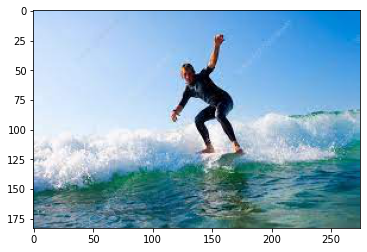

In [44]:
max_len = 34

feature = test_feature_extraction(test_data_path, "inceptionv3")
feature = feature.reshape((1,2048))
img = Image.open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/test1.jpg")


plt.imshow(img)
model_evaluation(model2, tokenizer, val_features, val_captions, max_len, 3)
model_evaluation_greedy_search(model2, tokenizer, val_features, val_captions, max_len)
description = generate_description(model2, tokenizer, feature, max_len)
beam_descrption = generate_caption_beam_search(model2, tokenizer, feature, max_len, 3)
print(description)
print("beam", beam_descrption) 

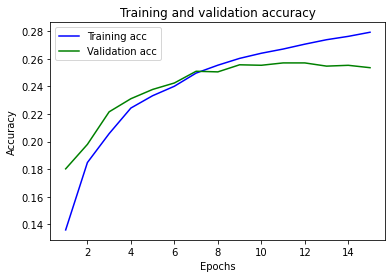

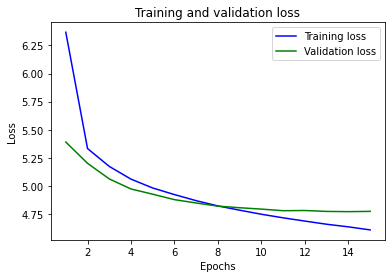

In [45]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [46]:
train_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.trainImages.txt"
val_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.devImages.txt"
model_selection = "Xception"
train_features, train_captions, max_len = get_train_data(train_dataset,path_for_extracted_features_captions,model_selection)
val_features,val_captions = get_val_data(val_dataset,path_for_extracted_features_captions,model_selection)
print(train_features['10815824_2997e03d76'])


model3 = rnn(vocab_size, max_len, model_config, model_selection)
model3.layers[2].set_weights([embedding_matrix])
model3.layers[2].trainable = False
opt = keras.optimizers.Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

batch_size = 64
train_steps = np.ceil(len(train_captions)/batch_size)
val_steps  = np.ceil(len(val_captions)/batch_size)
epochs=15
print(train_steps,val_steps)
model_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+'LSTM_model_glove.hdf5'
#checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpointer = [checkpoint]
history_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/xception/model_"+model_selection+"LSTM_model_glove"

[0.02142421 0.1410758  0.09508835 ... 0.07635967 0.17963612 0.01355512]
94.0 16.0


In [47]:
train_data_generator = generate_seq_update(train_features, train_captions, max_len, batch_size, vocab_size, tokenizer)
val_data_generator = generate_seq_update(val_features, val_captions, max_len, batch_size, vocab_size, tokenizer)
history3 = model3.fit(train_data_generator, epochs=epochs, steps_per_epoch = train_steps, validation_data=val_data_generator, validation_steps= val_steps, verbose=1)
model3.save(model_save_path)
with open(history_save_path, 'wb') as file_pi:
  dump(history3.history, file_pi)
print("Done with epoch ")
print('\n\n\n\n')

Epoch 1/15
94/94 [==============================] - 36s 336ms/step - loss: 11.8143 - accuracy: 0.0944 - val_loss: 5.9572 - val_accuracy: 0.1362
Epoch 2/15
94/94 [==============================] - 30s 319ms/step - loss: 5.8260 - accuracy: 0.1462 - val_loss: 5.5244 - val_accuracy: 0.1719
Epoch 3/15
94/94 [==============================] - 30s 323ms/step - loss: 5.5190 - accuracy: 0.1725 - val_loss: 5.4023 - val_accuracy: 0.1810
Epoch 4/15
94/94 [==============================] - 30s 323ms/step - loss: 5.4193 - accuracy: 0.1816 - val_loss: 5.3291 - val_accuracy: 0.1961
Epoch 5/15
94/94 [==============================] - 30s 324ms/step - loss: 5.3441 - accuracy: 0.1938 - val_loss: 5.2773 - val_accuracy: 0.2009
Epoch 6/15
94/94 [==============================] - 30s 318ms/step - loss: 5.2960 - accuracy: 0.2007 - val_loss: 5.2460 - val_accuracy: 0.2047
Epoch 7/15
94/94 [==============================] - 30s 318ms/step - loss: 5.2636 - accuracy: 0.2044 - val_loss: 5.2123 - val_accuracy: 0.208

100%|██████████| 1000/1000 [1:10:08<00:00,  4.21s/it]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.524532
BLEU-2: 0.238220
BLEU-3: 0.136335


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-4: 0.051283


100%|██████████| 1000/1000 [06:24<00:00,  2.60it/s]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.452925
BLEU-2: 0.219699
BLEU-3: 0.130496
BLEU-4: 0.053567
startseq two dogs are are in the water endseq
beam startseq man in red shirt is playing in the grass endseq


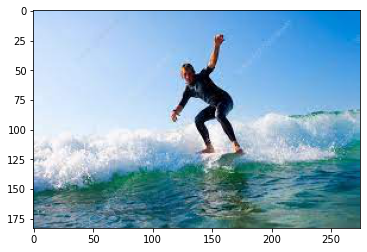

In [48]:
max_len = 34

feature = test_feature_extraction(test_data_path, "Xception")
feature = feature.reshape((1,2048))
img = Image.open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/test1.jpg")


plt.imshow(img)
model_evaluation(model3, tokenizer, val_features, val_captions, max_len, 3)
model_evaluation_greedy_search(model3, tokenizer, val_features, val_captions, max_len)
description = generate_description(model3, tokenizer, feature, max_len)
beam_descrption = generate_caption_beam_search(model3, tokenizer, feature, max_len, 3)
print(description)
print("beam", beam_descrption) 

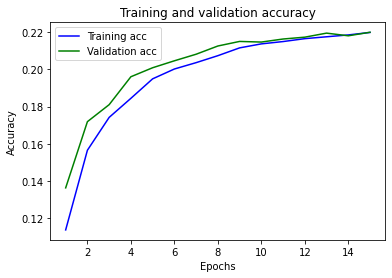

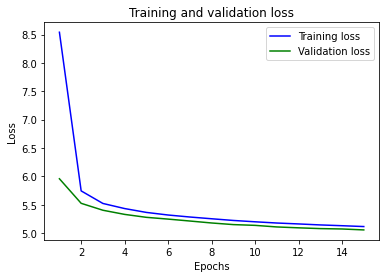

In [49]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [50]:
train_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.trainImages.txt"
val_dataset="/content/gdrive/MyDrive/DEEP LEARNING/dataset/Flickr_8k.devImages.txt"
model_selection = "inceptionv3"
train_features, train_captions, max_len = get_train_data(train_dataset,path_for_extracted_features_captions,model_selection)
val_features,val_captions = get_val_data(val_dataset,path_for_extracted_features_captions,model_selection)
print(train_features['10815824_2997e03d76'])


model4 = rnn(vocab_size, max_len, model_config, model_selection)
model4.layers[2].set_weights([embedding_matrix])
model4.layers[2].trainable = False
opt = keras.optimizers.Adam(learning_rate=0.001)
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

batch_size = 64
train_steps = np.ceil(len(train_captions)/batch_size)
val_steps  = np.ceil(len(val_captions)/batch_size)
epochs=15
print(train_steps,val_steps)
model_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/inception/model_"+model_selection+'LSTM_model_glove.hdf5'
#checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
#checkpointer = [checkpoint]
history_save_path = "/content/gdrive/MyDrive/DEEP LEARNING/project/inception/model_"+model_selection+"LSTM_model_glove"

[0.34266418 0.16739696 0.09924389 ... 0.21216701 0.46709603 0.25276417]
94.0 16.0


In [51]:
train_data_generator = generate_seq_update(train_features, train_captions, max_len, batch_size, vocab_size, tokenizer)
val_data_generator = generate_seq_update(val_features, val_captions, max_len, batch_size, vocab_size, tokenizer)
history4 = model4.fit(train_data_generator, epochs=epochs, steps_per_epoch = train_steps, validation_data=val_data_generator, validation_steps= val_steps, verbose=1)
model4.save(model_save_path)
with open(history_save_path, 'wb') as file_pi:
  dump(history4.history, file_pi)
print("Done with epoch ")
print('\n\n\n\n')

Epoch 1/15
94/94 [==============================] - 35s 329ms/step - loss: 11.6629 - accuracy: 0.0987 - val_loss: 5.8996 - val_accuracy: 0.1477
Epoch 2/15
94/94 [==============================] - 29s 313ms/step - loss: 5.7550 - accuracy: 0.1576 - val_loss: 5.4456 - val_accuracy: 0.1832
Epoch 3/15
94/94 [==============================] - 29s 315ms/step - loss: 5.4214 - accuracy: 0.1889 - val_loss: 5.2897 - val_accuracy: 0.2009
Epoch 4/15
94/94 [==============================] - 29s 315ms/step - loss: 5.2985 - accuracy: 0.2022 - val_loss: 5.2141 - val_accuracy: 0.2095
Epoch 5/15
94/94 [==============================] - 29s 315ms/step - loss: 5.2283 - accuracy: 0.2122 - val_loss: 5.1656 - val_accuracy: 0.2172
Epoch 6/15
94/94 [==============================] - 29s 315ms/step - loss: 5.1868 - accuracy: 0.2186 - val_loss: 5.1349 - val_accuracy: 0.2229
Epoch 7/15
94/94 [==============================] - 30s 317ms/step - loss: 5.1574 - accuracy: 0.2225 - val_loss: 5.1075 - val_accuracy: 0.224

100%|██████████| 1000/1000 [1:11:25<00:00,  4.29s/it]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.511132
BLEU-2: 0.255853
BLEU-3: 0.163303


  0%|          | 0/1000 [00:00<?, ?it/s]

BLEU-4: 0.069414


100%|██████████| 1000/1000 [07:35<00:00,  2.20it/s]


BLEU Scores :
A perfect match results in a score of 1.0, whereas a perfect mismatch results in a score of 0.0.
BLEU-1: 0.461184
BLEU-2: 0.230644
BLEU-3: 0.148037
BLEU-4: 0.060843
startseq two people are playing in the water endseq
beam startseq man in red shirt is playing in the water endseq


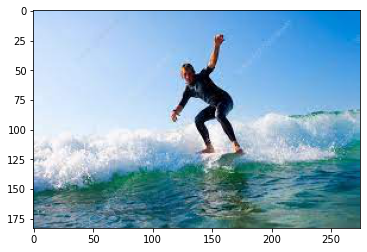

In [52]:
max_len = 34

feature = test_feature_extraction(test_data_path, "inceptionv3")
feature = feature.reshape((1,2048))
img = Image.open("/content/gdrive/MyDrive/DEEP LEARNING/dataset/test_dataset/test1.jpg")


plt.imshow(img)
model_evaluation(model4, tokenizer, val_features, val_captions, max_len, 3)
model_evaluation_greedy_search(model4, tokenizer, val_features, val_captions, max_len)
description = generate_description(model4, tokenizer, feature, max_len)
beam_descrption = generate_caption_beam_search(model4, tokenizer, feature, max_len, 3)
print(description)
print("beam", beam_descrption) 

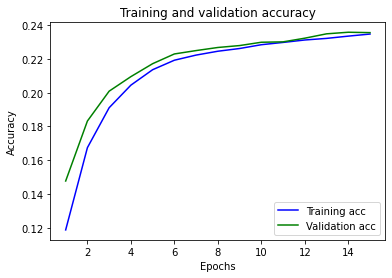

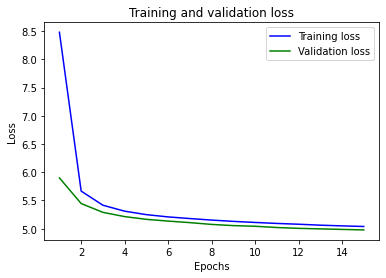

In [53]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'g', label='Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
fig = plt.figure()
fig.savefig('acc.png')


plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()